In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import json
import os
import random

import numpy as np
import torch
import scipy.io

from experiment import lesion
from experiment import mRNN
from experiment import michaels_load
from experiment import stim
from experiment import utils

#CUDA = torch.device(0)
CUDA = None

# XXX These are not Windows-compatible paths. Too lazy to tokenize and join.
PATH_M1_NO_COADAPT = "models/gaussian20.1.75_outputsIdxs0.50_gaussianExp16.2.175_enActTanh_cpnActTanh/6b424a9c-8308-4bc2-b165-7f2fc078c783"
PATH_M1_COADAPT = "models/gaussian20.1.75_outputsIdxs0.50_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/0a2a06be-56e8-4692-8f18-64a021ab8933"

PATH_AIP_NO_COADAPT = "models/gaussian20.1.75_outputsIdxs200.250_gaussianExp16.2.175_enActTanh_cpnActTanh/16130497-5e97-4396-aed7-540c5863cdd7"
PATH_AIP_COADAPT = "models/gaussian20.1.75_outputsIdxs200.250_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/d5cb145f-9ea9-402c-981a-4780b47d9f79"

PATH_CON_NO_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh/c7583779-4622-40a6-a259-59f2e8c0cfd9"
PATH_CON_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/d6304fab-9cfd-4bff-ba29-32872a75a3d0"

PATH_PRERECOV_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh_recovPre_coadapt/f692f909-5396-42a7-ab40-6f438cd4ab13"

PATH_SENSOR_DRIFT = "models/gaussianDrifting20.1.75.0.0015_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/27d3fbcb-9938-4c29-a6d9-7962d44e508c"

In [2]:
# Two part stopping policy:
# * Go no longer than 250000 epochs, so we have a hard stop
# * If the pct change in task loss b/w two consecutive 500 epoch windows is <0.01%, then stop

def apply_policy(recs, max_run_len=250000):    
    orig_min_loss = 100
    orig_min_val_loss = 100
    min_loss = 100
    min_val_loss = 100
    found_thresh = False
    orig_run_length = 0
    run_length = 0
    prev_500 = []
    current_500 = []
    for r in recs:
        orig_run_length += 1
        if not found_thresh:
            run_length += 1
                    
        try:
            if r['user']['epoch_type'] != "CPN":
                continue
                
            tl = float(r['task_loss'])
            tlv = float(r['task_val_loss'])
        except (ValueError, KeyError):
            continue
        
        if tl < orig_min_loss:
            orig_min_loss = tl
        if tlv < orig_min_val_loss:
            orig_min_val_loss = tlv
            
        if max_run_len and (orig_run_length) >= max_run_len:
            found_thresh = True
            
        if not found_thresh:           
            if tl < min_loss:
                min_loss = tl
            if tlv < min_val_loss:
                min_val_loss = tlv
            
            current_500.append(tl)
                
            if len(prev_500) == 500 and len(current_500) == 500:
                prev_mean = sum(prev_500) / 500.0
                cur_mean = sum(current_500) / 500.0
                
                pct_diff = abs((cur_mean - prev_mean) / prev_mean)
                if pct_diff <= 0.0001:
                    found_thresh = True
                    
            if len(current_500) == 500:
                prev_500 = current_500
                current_500 = []
    
    return run_length, min_loss, min_val_loss, orig_run_length, orig_min_loss, orig_min_val_loss

In [3]:
EPOCH_SCALAR = 100.0

def recover_pct_loss_eq(tl1, pr1, tl2, pr2):
    m = (pr2 - pr1) / (tl2 - tl1)
    c = pr1 - m * tl1
    
    lesion_loss = (-c) / m
    healthy_loss = (1 - c) / m
    
    print(lesion_loss, healthy_loss)
    
    return m, c

def loss_eq_from_hist(task_loss_recs, pct_recov_recs):
    tl1 = None
    tl2 = None
    id1 = None
    id2 = None
    for idx, r in enumerate(task_loss_recs):
        if tl1 is None:
            tl1 = r
            id1 = idx
        elif r != tl1:
            tl2 = r
            id2 = idx
            break
            
    pr1 = pct_recov_recs[id1]
    pr2 = pct_recov_recs[id2]
            
    return recover_pct_loss_eq(tl1, pr1, tl2, pr2)

def graph_results(root_path, fig, axs_loss, axs_sep, healthy_loss, lesioned_loss, apply_stopping_condition=True):
    log_path = os.path.join(root_path, "log")
    
    recs = json.load(open(log_path, "r"))
    
    if apply_stopping_condition:
        run_length, _, _, _, _, _ = apply_policy(recs)
    else:
        run_length = len(recs)

    
    pct_recov = []
    task_loss = []
    sep = []
    eidx = 0
    for r in recs:
        eidx += 1
        if eidx >= run_length:
            break
            
        try:
            sep_c = float(r['class_separation'])
            tl_c = float(r['task_loss'])
            recov_c = 1 - (tl_c - healthy_loss) / (lesioned_loss - healthy_loss)
        except ValueError:
            continue
            
        pct_recov.append(100.0 * recov_c)
        task_loss.append(tl_c)
        sep.append(sep_c)
        
    pct_recov_val = []
    eidx = 0
    for r in recs:
        eidx += 1
        if eidx >= run_length:
            break
            
        try:
            loss_val = float(r['task_val_loss'])
        except ValueError:
            continue
        
        prcv = 1 - (loss_val - healthy_loss) / (lesioned_loss - healthy_loss)
        pct_recov_val.append(100.0 * prcv)

        
    epoch_count = len(pct_recov)
        
    axs_loss.plot([eidx / EPOCH_SCALAR for eidx in range(len(pct_recov))], pct_recov, color="tab:blue", label="loss")
    axs_loss.plot([eidx / EPOCH_SCALAR for eidx in range(len(pct_recov_val))], pct_recov_val, color="tab:orange", label="val. loss")
    ylim = list(axs_loss.get_ylim())
    ylim[-1] = 100.0
    axs_loss.set_ylim(ylim)
    
    axs_sep.plot([eidx / EPOCH_SCALAR for eidx in range(len(sep))], sep, color="tab:purple", label="separation")
    axs_sep.plot([0, epoch_count / EPOCH_SCALAR], [0.0, 0.0], color='black', linestyle='-', linewidth=1)
    
    return pct_recov, pct_recov_val, sep

In [6]:
def calc_text_xy(axis, pos_is_top):
    
    minx, maxx = axis.get_xlim()
    miny, maxy = axis.get_ylim()
    
    if pos_is_top:
        max_mod = 0.80
    else:
        max_mod = 0.10
    
    maxx_mod = 0.80
    tx = minx * (1 - maxx_mod) + maxx * maxx_mod
    ty = max_mod * maxy + (1 - max_mod) * miny   
    
    return tx, ty

def graph_run(log_path, loss_healthy, loss_lesioned, fig, subplot1, subplot2,
              loss_label, sep_label, apply_stopping_condition=True,
              pos_is_top=(False, True)):
    axs_loss = plt.Subplot(fig, subplot1)
    axs_sep = plt.Subplot(fig, subplot2)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)
    
    pct_recov, pct_recov_val, sep = graph_results(log_path, fig, axs_loss, axs_sep,
                  loss_healthy, loss_lesioned, apply_stopping_condition=apply_stopping_condition)
    
    tx, ty = calc_text_xy(axs_loss, pos_is_top[0])
    axs_loss.text(tx, ty, loss_label, fontsize='x-large', fontfamily='serif')

    tx, ty = calc_text_xy(axs_sep, pos_is_top[1])
    axs_sep.text(tx, ty, sep_label, fontsize='x-large', fontfamily='serif')
    
    return axs_loss, axs_sep


def graph_single(log_path, loss_healthy, loss_lesioned, title, fig, grid_subplot,
                 apply_stopping_condition=True, pos_is_top=(False, True)):
#     title_sp = plt.Subplot(fig, grid_subplot)
#     title_sp.set_title(title, fontsize=20, pad=34)
#     title_sp.axis('off')
#     fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
            subplot_spec=grid_subplot, hspace=0.30)
    
    axs_loss, axs_sep = graph_run(log_path, loss_healthy, loss_lesioned, fig, inner[0], inner[1],
                                  'a.', 'b.', apply_stopping_condition=apply_stopping_condition,
                                  pos_is_top=pos_is_top)


    axs_loss.set_title(" ", fontsize=14, y=1.05)
    axs_loss.set_ylabel("% Recovery", fontsize=12)
    axs_sep.set_ylabel("Within class\nseparation vs healthy", fontsize=12)
    axs_sep.set_xlabel("Training epoch (100s)", fontsize=12)

    return axs_loss, axs_sep

def graph_dual(log_path1, log_path2, loss_healthy, loss_lesioned, title, fig, grid_subplot,
              pos_is_top=(False, True)):
#     title_sp = plt.Subplot(fig, grid_subplot)
#     title_sp.set_title(title, fontsize=20, pad=34)
#     title_sp.axis('off')
#     fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=grid_subplot, wspace=0.45, hspace=0.30)
    
    axs_loss1, axs_sep1 = graph_run(log_path1, loss_healthy, loss_lesioned, fig, inner[0, 0], inner[1, 0],
                                   'a.', 'b.', pos_is_top=pos_is_top)
    axs_loss2, axs_sep2 = graph_run(log_path2, loss_healthy, loss_lesioned, fig, inner[0, 1], inner[1, 1],
                                   'c.', 'd.', pos_is_top=pos_is_top)
    
    orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
    blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
    purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
    plt.legend(handles=[orange_patch, blue_patch, purple_patch], loc="lower center",
           bbox_to_anchor=(-0.32, -0.72), ncol=3)

    axs_loss1.set_title("No Co-Adaptation", fontsize=14, y=1.05)
    axs_loss1.set_ylabel("% Recovery", fontsize=12)
    axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=12)
    axs_sep1.set_xlabel("Training epoch (100s)", fontsize=12)
    axs_loss2.set_title("Co-Adaptation", fontsize=14, y=1.05)

    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

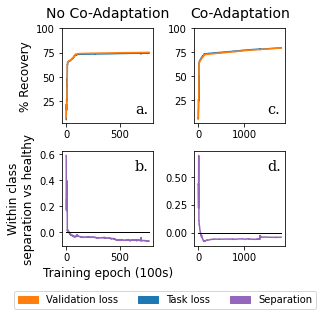

In [7]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)

axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(PATH_M1_NO_COADAPT, PATH_M1_COADAPT,
                                                     0.00056639, 0.02113609, "M1 50% Lesion",
                                                     fig, outer[0])

plt.savefig('paper/figs/training_results_m1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Conclusion: recovery possible in both cases
# Conclusion: class separation improves after initially being low

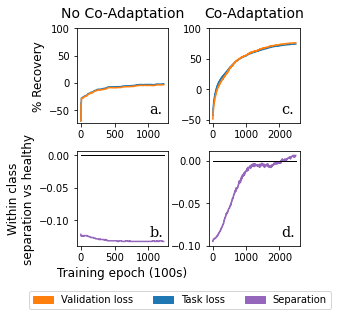

In [8]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)

axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT,
                                                     0.00056639, 0.00450741, "AIP 50% Lesion",
                                                     fig, outer[0], pos_is_top=(False, False))

plt.savefig('paper/figs/training_results_aip.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

# Conclusion: loss of encoding machinery means we don't have information enough to condition stimulus
# Conclusion: with co-adaptation, the two work together to solve the problem
# Non-conclusion: recovery alone would/wouldn't solve the problem

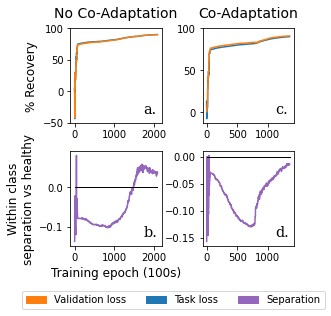

In [9]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)

axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(PATH_CON_NO_COADAPT, PATH_CON_COADAPT,
                                                     0.00056639, 0.02071923, "F5<->M1 Connection\nLesion",
                                                     fig, outer[0], pos_is_top=(False, False))

plt.savefig('paper/figs/training_results_con.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

# Conclusion: recovery is steady after an initial rapid improvement
# Conclusion: initially the structure of the problem (i.e. hold) is learned, followed by object differentiation

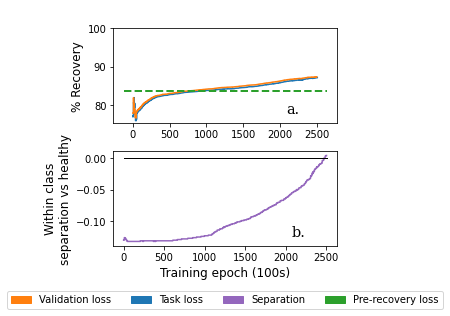

In [29]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)
   
axs_loss, axs_sep = graph_single(PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923, "Connection Lesion\nw/Recovery",
                                 fig, outer[0], pos_is_top=(False, False))

prerecov_pct = (1 - (0.00383386 - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)

orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
green_patch = mpatches.Patch(color='tab:green', label='Pre-recovery loss')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(0.5, -0.72), ncol=4)
    
plt.savefig('paper/figs/training_results_recov.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

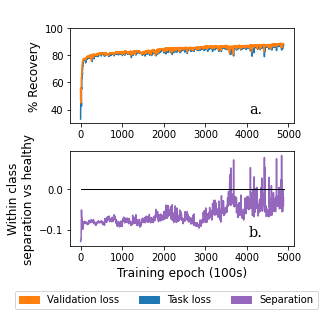

In [32]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)
   
axs_loss, axs_sep = graph_single(PATH_SENSOR_DRIFT, 0.0005700110132158619, 0.02076151396694215,
                                 "Connection Lesion\nw/Sensor Drift",
                                 fig, outer[0], apply_stopping_condition=False,
                                 pos_is_top=(False, False))

orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
plt.legend(handles=[orange_patch, blue_patch, purple_patch], loc="lower center",
           bbox_to_anchor=(0.43, -0.72), ncol=3)
    
plt.savefig('paper/figs/training_results_drift.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
# Pre-load the data
paths = [PATH_M1_NO_COADAPT, PATH_M1_COADAPT,PATH_AIP_NO_COADAPT,
         PATH_AIP_COADAPT, PATH_CON_NO_COADAPT, PATH_CON_COADAPT, PATH_PRERECOV_COADAPT,
         PATH_SENSOR_DRIFT]

recs = []
for path in paths:
    log_path = os.path.join(path, "log")
    cur_recs = json.load(open(log_path, "r"))
    recs.append(cur_recs)

In [18]:
#print(apply_policy(recs[0]))
for r in recs:
    res = apply_policy(r)
    print(res, " *" if res[0] == res[-3] else "")
    
#for r in recs:
#    print(len(r))

(76987, 0.005815, 0.00564, 244100, 0.005764, 0.005604) 
(180450, 0.004772, 0.004815, 180450, 0.004772, 0.004815)  *
(123650, 0.004599, 0.004658, 123650, 0.004599, 0.004658)  *
(250487, 0.001582, 0.001502, 257900, 0.001575, 0.001502) 
(208650, 0.002584, 0.002583, 208650, 0.002584, 0.002583)  *
(136150, 0.002583, 0.002405, 136150, 0.002583, 0.002405)  *
(250618, 0.003136, 0.003099, 259050, 0.003105, 0.003077) 
(250018, 0.003608, 0.003432, 488250, 0.002966, 0.002825) 


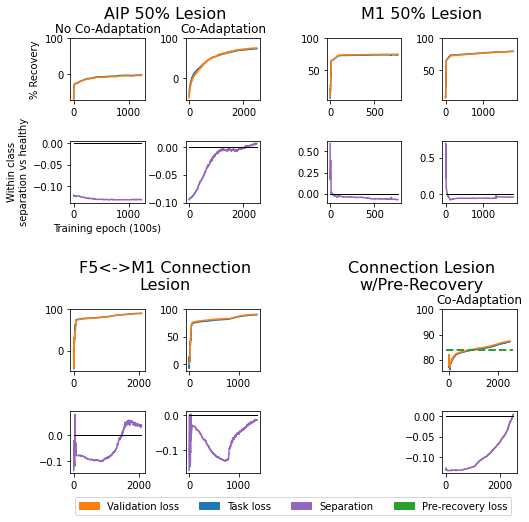

In [19]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.35, hspace=0.65)

def graph_category(fig, subplot, title, path1, path2, healthy_loss, lesioned_loss):
    
    title_sp = plt.Subplot(fig, subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
        
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=subplot, wspace=0.55, hspace=0.65)
    
    axs_loss1 = plt.Subplot(fig, inner[0, 0])
    axs_sep1 = plt.Subplot(fig, inner[1, 0])
    if path1 is not None:    
        graph_results(path1, fig, axs_loss1, axs_sep1, healthy_loss, lesioned_loss)
    fig.add_subplot(axs_loss1)
    fig.add_subplot(axs_sep1)
        
    axs_loss2 = plt.Subplot(fig, inner[0, 1])
    axs_sep2 = plt.Subplot(fig, inner[1, 1])    
    if path2 is not None:
        graph_results(path2, fig, axs_loss2, axs_sep2, healthy_loss, lesioned_loss)
    fig.add_subplot(axs_loss2)
    fig.add_subplot(axs_sep2)
    
    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

def graph_single(fig, subplot, title, path, healthy_loss, lesioned_loss):
    
    title_sp = plt.Subplot(fig, subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
        
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=subplot, wspace=0.55, hspace=0.65)
    
        
    axs_loss0 = plt.Subplot(fig, inner[0, 0])
    axs_sep0 = plt.Subplot(fig, inner[1, 0])
    axs_loss0.axis('off')
    axs_sep0.axis('off')
    fig.add_subplot(axs_loss0)
    fig.add_subplot(axs_sep0)
    
    axs_loss = plt.Subplot(fig, inner[0, 1])
    axs_sep = plt.Subplot(fig, inner[1, 1])
    if path is not None:    
        graph_results(path, fig, axs_loss, axs_sep, healthy_loss, lesioned_loss)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)

    
    return axs_loss, axs_sep

axs_loss1, axs_sep1, axs_loss2, _ = graph_category(fig, outer[0], "AIP 50% Lesion",
                                                   PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT,
                                                   0.00056639, 0.00450741)
axs_loss1.set_title("No Co-Adaptation", fontsize=12)
axs_loss1.set_ylabel("% Recovery", fontsize=10)
axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=10)
axs_sep1.set_xlabel("Training epoch (100s)", fontsize=10)
axs_loss2.set_title("Co-Adaptation", fontsize=12)

graph_category(fig, outer[1], "M1 50% Lesion", PATH_M1_NO_COADAPT, PATH_M1_COADAPT,
            0.00056639, 0.02113609)
graph_category(fig, outer[2], "F5<->M1 Connection\nLesion", PATH_CON_NO_COADAPT, PATH_CON_COADAPT,
              0.00056639, 0.02071923)


axs_loss, _ = graph_single(fig, outer[3], "Connection Lesion\nw/Pre-Recovery",
                                           PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923)
prerecov_pct = (1 - (0.00383386 - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)
axs_loss.set_title("Co-Adaptation", fontsize=12)

orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
green_patch = mpatches.Patch(color='tab:green', label='Pre-recovery loss')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(-2.0, -0.75), ncol=4)

# plt.savefig('paper/figs/training_results.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

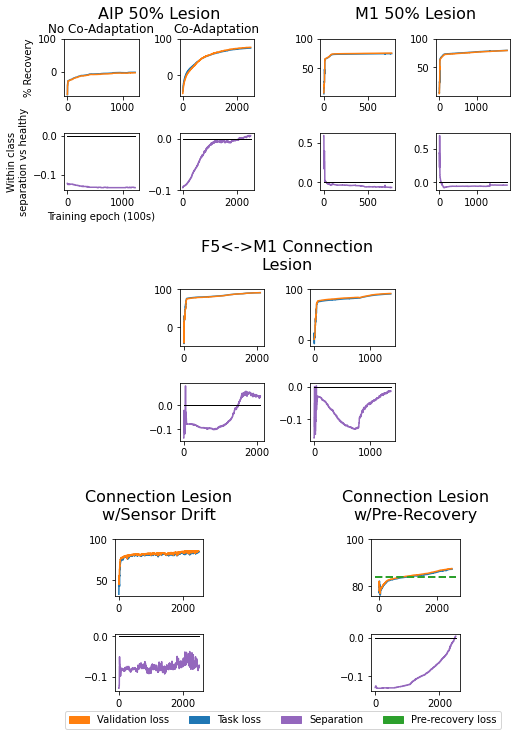

In [92]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 12))
outer = gridspec.GridSpec(3, 1, hspace=0.65)#, height_ratios=[2, 1])

# The three vanilla experiments.
# Top row has two, bottom row has 3.
outer_top = outer[0]
# The coadapt and sensor drift experiments
outer_middle = outer[1]
# The coadapt and sensor drift experiments
outer_bottom = outer[2]

top_subplot = plt.Subplot(fig, outer_top)
top_subplot.axis('off')
fig.add_subplot(top_subplot)

middle_subplot = plt.Subplot(fig, outer_middle)
middle_subplot.axis('off')
fig.add_subplot(middle_subplot)

bottom_subplot = plt.Subplot(fig, outer_bottom)
bottom_subplot.axis('off')
fig.add_subplot(bottom_subplot)

top_grid = gridspec.GridSpecFromSubplotSpec(1, 2,
            subplot_spec=top_subplot, wspace=0.35)
middle_grid = gridspec.GridSpecFromSubplotSpec(1, 4,
            subplot_spec=middle_subplot, wspace=0.175)
bottom_grid_outer = gridspec.GridSpecFromSubplotSpec(1, 2,
            subplot_spec=bottom_subplot, wspace=0.35)
bottom_grid_left = gridspec.GridSpecFromSubplotSpec(1, 4,
            subplot_spec=bottom_grid_outer[0], wspace=0.35)
bottom_grid_right = gridspec.GridSpecFromSubplotSpec(1, 4,
            subplot_spec=bottom_grid_outer[1], wspace=0.35)

def graph_run(log_path, loss_healthy, loss_lesioned, fig, subplot1, subplot2):
    axs_loss = plt.Subplot(fig, subplot1)
    axs_sep = plt.Subplot(fig, subplot2)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)
    
    graph_results(log_path, fig, axs_loss, axs_sep, loss_healthy, loss_lesioned)
    
    return axs_loss, axs_sep
    

def graph_dual(log_path1, log_path2, loss_healthy, loss_lesioned, title, fig, grid_subplot):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=grid_subplot, wspace=0.55, hspace=0.65)
    
    axs_loss1, axs_sep1 = graph_run(log_path1, loss_healthy, loss_lesioned, fig, inner[0, 0], inner[1, 0])
    axs_loss2, axs_sep2 = graph_run(log_path2, loss_healthy, loss_lesioned, fig, inner[0, 1], inner[1, 1])

    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

    
def graph_single(log_path, loss_healthy, loss_lesioned, title, fig, grid_subplot):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
            subplot_spec=grid_subplot, wspace=0.55, hspace=0.65)
    
    axs_loss, axs_sep = graph_run(log_path, loss_healthy, loss_lesioned, fig, inner[0], inner[1])

    return axs_loss, axs_sep



axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(
    PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT, 0.00056639, 0.00450741,
    "AIP 50% Lesion", fig, top_grid[0])
axs_loss1.set_title("No Co-Adaptation", fontsize=12)
axs_loss1.set_ylabel("% Recovery", fontsize=10)
axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=10)
axs_sep1.set_xlabel("Training epoch (100s)", fontsize=10)
axs_loss2.set_title("Co-Adaptation", fontsize=12)

graph_dual(PATH_M1_NO_COADAPT, PATH_M1_COADAPT, 0.00056639, 0.02113609,
    "M1 50% Lesion", fig, top_grid[1])
graph_dual(PATH_CON_NO_COADAPT, PATH_CON_COADAPT, 0.00056639, 0.02071923,
    "F5<->M1 Connection\nLesion", fig, middle_grid[1:3])

graph_single(PATH_SENSOR_DRIFT, 0.0005700110132158619, 0.02076151396694215,
             "Connection Lesion\nw/Sensor Drift", fig, bottom_grid_left[1:3])
axs_loss, _ = graph_single(PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923,
                          "Connection Lesion\nw/Pre-Recovery", fig, bottom_grid_right[1:3])
prerecov_pct = (1 - (0.00383386 - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)


orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
green_patch = mpatches.Patch(color='tab:green', label='Pre-recovery loss')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(-1.0, -0.75), ncol=4)

# plt.savefig('paper/figs/training_results.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

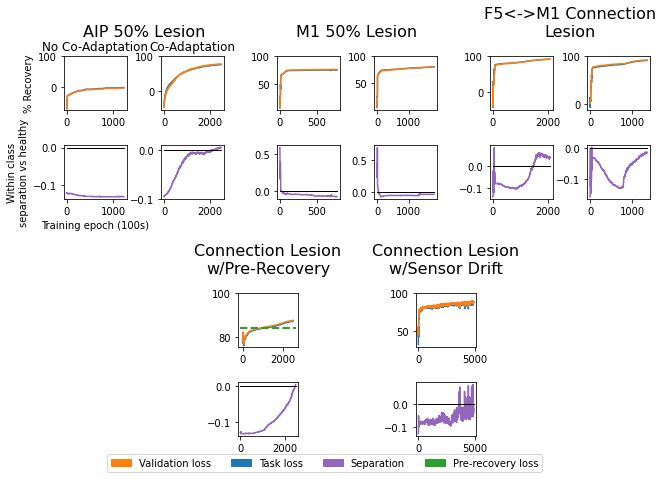

In [117]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10.5, 7))
outer = gridspec.GridSpec(2, 1, hspace=0.65)

# The three vanilla experiments.
# Top row has two, bottom row has 3.
outer_top = outer[0]
# The coadapt and sensor drift experiments
outer_bottom = outer[1]

top_subplot = plt.Subplot(fig, outer_top)
top_subplot.axis('off')
fig.add_subplot(top_subplot)

bottom_subplot = plt.Subplot(fig, outer_bottom)
bottom_subplot.axis('off')
fig.add_subplot(bottom_subplot)

top_grid = gridspec.GridSpecFromSubplotSpec(1, 3,
            subplot_spec=top_subplot, wspace=0.333)
bottom_grid_outer = gridspec.GridSpecFromSubplotSpec(1, 2,
            subplot_spec=bottom_subplot, wspace=0.5)
bottom_grid_left = gridspec.GridSpecFromSubplotSpec(1, 3,
            subplot_spec=bottom_grid_outer[0], wspace=0.43)
bottom_grid_right = gridspec.GridSpecFromSubplotSpec(1, 3,
            subplot_spec=bottom_grid_outer[1], wspace=0.43)

def graph_run(log_path, loss_healthy, loss_lesioned, fig, subplot1, subplot2,
              apply_stopping_condition=True):
    axs_loss = plt.Subplot(fig, subplot1)
    axs_sep = plt.Subplot(fig, subplot2)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)
    
    graph_results(log_path, fig, axs_loss, axs_sep, loss_healthy, loss_lesioned,
                  apply_stopping_condition=apply_stopping_condition)
    
    return axs_loss, axs_sep
    

def graph_dual(log_path1, log_path2, loss_healthy, loss_lesioned, title, fig, grid_subplot):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=grid_subplot, wspace=0.55, hspace=0.65)
    
    axs_loss1, axs_sep1 = graph_run(log_path1, loss_healthy, loss_lesioned, fig, inner[0, 0], inner[1, 0])
    axs_loss2, axs_sep2 = graph_run(log_path2, loss_healthy, loss_lesioned, fig, inner[0, 1], inner[1, 1])

    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

    
def graph_single(log_path, loss_healthy, loss_lesioned, title, fig, grid_subplot,
                 apply_stopping_condition=True):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
            subplot_spec=grid_subplot, hspace=0.65)
    
    axs_loss, axs_sep = graph_run(log_path, loss_healthy, loss_lesioned, fig, inner[0], inner[1],
                                  apply_stopping_condition=apply_stopping_condition)

    return axs_loss, axs_sep


axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(
    PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT, 0.00056639, 0.00450741,
    "AIP 50% Lesion", fig, top_grid[0])
axs_loss1.set_title("No Co-Adaptation", fontsize=12)
axs_loss1.set_ylabel("% Recovery", fontsize=10)
axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=10)
axs_sep1.set_xlabel("Training epoch (100s)", fontsize=10)
axs_loss2.set_title("Co-Adaptation", fontsize=12)

graph_dual(PATH_M1_NO_COADAPT, PATH_M1_COADAPT, 0.00056639, 0.02113609,
    "M1 50% Lesion", fig, top_grid[1])
graph_dual(PATH_CON_NO_COADAPT, PATH_CON_COADAPT, 0.00056639, 0.02071923,
    "F5<->M1 Connection\nLesion", fig, top_grid[2])


axs_loss, _ = graph_single(PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923,
                          "Connection Lesion\nw/Pre-Recovery", fig, bottom_grid_left[2])
prerecov_pct = (1 - (0.00383386 - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)

graph_single(PATH_SENSOR_DRIFT, 0.0005700110132158619, 0.02076151396694215,
             "Connection Lesion\nw/Sensor Drift", fig, bottom_grid_right[0],
             apply_stopping_condition=False)

orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
green_patch = mpatches.Patch(color='tab:green', label='Pre-recovery loss')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(-1.5, -0.75), ncol=4)

plt.savefig('paper/figs/training_results.png', format='png', dpi=300, bbox_inches='tight')

plt.show()